In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

%matplotlib inline

In [164]:
data = pd.read_csv('data\survey_data.csv',low_memory=False)

In [165]:
#split out demographic data
demo_columns = ['age','gender','education','employment_status',
       'household_income','subjective_income','geography',
       'country','country_income','Q27','Q28','D1','Q29','Q30','ViewOfScience']

In [166]:
#add demographic data to dictionaries mapped to id
for i in demo_columns:
    globals()[i] = dict(zip(data['id'],data[i]))

In [235]:
df = data[['id','Q8', 'Q9', 'Q10A', 'Q10B', 'Q11A', 'Q11B',
       'Q11C', 'Q11D', 'Q11E', 'Q11F', 'Q11G', 'Q12', 'Q13', 'Q14A', 'Q14B',
       'Q15A', 'Q15B', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21', 'Q22',
       'Q24', 'Q25', 'Q26']].copy()

In [236]:
#Q20 is a discrete choice which doesn't scale as an intuititive magnitude
#so data can be revised to answer question: do you trust doctor/nurse MOST to give you medical or health advice? Yes=1, different most trusted answer given = 0
def convAuthority(x):
    if x == 'doctor/nurse':
        return 1.0
    elif x == '!' or x == '?' or str(x) == 'nan':
        return None
    else:
        return 0

df['Q20'] = df['Q20'].apply(lambda x:convAuthority(x))

In [237]:
#standardise and remove rows with null fields and rows with questions unanswered
def nullResults(df):
    def nanNoAnswer(x):
        if x == '!' or x == '?' or str(x) == 'nan':
            return None
        else:
            return x
    
    for i in df.columns:
        df[i] = df[i].apply(lambda x:nanNoAnswer(x))
    
    df = df.dropna().reset_index()
    del df['index']
    
    return df

In [238]:
df = nullResults(df)

for i in df.columns[1:]:
    df[i] =  df[i].astype(float)

In [239]:
#pull features to be used for k-means

features = df.columns[1:]

X = df[features].values

In [240]:
X

array([[1.  , 1.  , 0.  , ..., 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       ...,
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 0.75],
       [1.  , 1.  , 0.  , ..., 1.  , 1.  , 1.  ]])

In [241]:
n = 4
kmeans = KMeans(n_clusters=n)
model = kmeans.fit(X)
print("model\n", model)

model
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


In [242]:
centers = model.cluster_centers_

In [243]:
#dataframe of cluster_n as index and feature centroids

P = pd.DataFrame(centers,
                 columns=features)

In [244]:
P

,Q8,Q9,Q10A,Q10B,Q11A,Q11B,Q11C,Q11D,Q11E,Q11F,...,Q16,Q17,Q18,Q19,Q20,Q21,Q22,Q24,Q25,Q26
0,1.000000,0.954771,0.999093,0.901380,0.731493,0.632392,0.786972,0.656976,0.826418,0.730416,...,0.728135,0.906625,0.967114,0.771530,0.844677,0.767245,0.839397,0.952987,0.873778,0.895150
1,0.957917,0.940102,0.000545,0.710144,0.667282,0.504516,0.720389,0.545304,0.754285,0.443859,...,0.665106,0.894656,0.955917,0.705599,0.837484,0.687229,0.782336,0.934671,0.837393,0.866365
2,0.001986,0.432410,0.691202,0.897301,0.753389,0.599062,0.749806,0.606382,0.838115,0.655202,...,0.683549,0.824045,0.920902,0.665615,0.845075,0.728201,0.830916,0.928000,0.838386,0.871451
3,0.755037,0.833067,0.374640,0.397186,0.496825,0.266246,0.438044,0.370378,0.506645,0.384484,...,0.254477,0.257515,0.658858,0.401103,0.620643,0.444958,0.544063,0.875819,0.716761,0.757755


In [245]:
def parallelPlot(data):
    '''plot feature centroids for each cluster'''
    colors = ['b', 'r', 'g', 'y', 'k', 'm','c']
    x = P.columns
    
    plt.figure(figsize=(20,8))
    for i in range(n):
        plt.plot(x,P.loc[i], c=colors[i], marker='o', label='cluster_'+str(i))
    plt.margins(x=0.01, y=0.03, tight=True)
    plt.grid()
    plt.legend(loc=4)

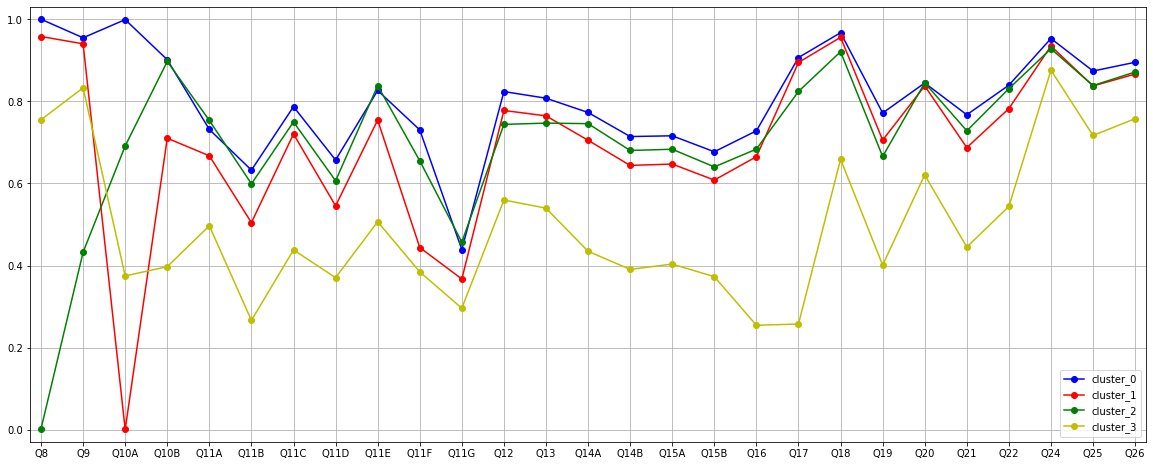

In [246]:
parallelPlot(P)

In [ ]:
parallelPlot(P)

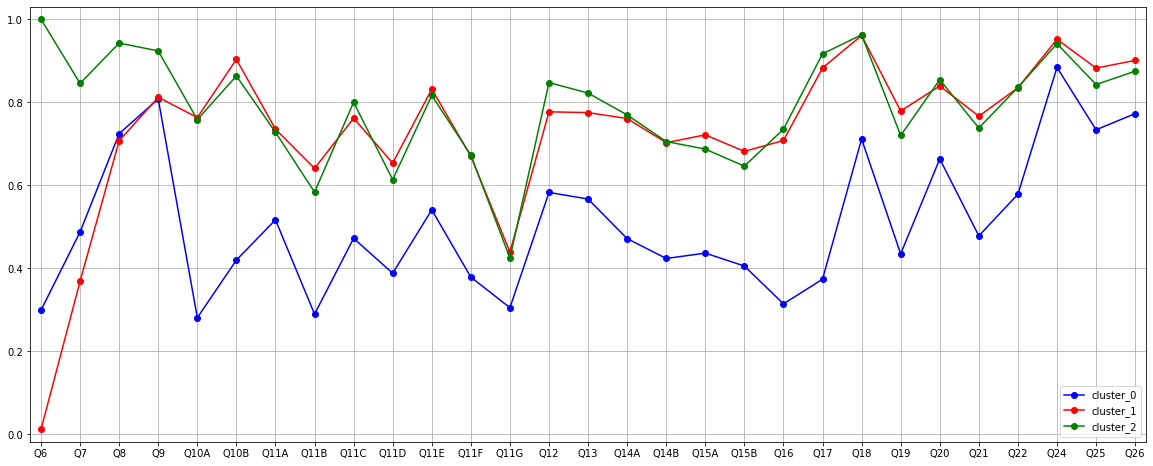

In [217]:
parallelPlot(P)

In [67]:
#add cluster_n to sample rows
ids = df.pop('id')
df['cluster_n'] = KMeans.fit_predict(model, df, y=None, sample_weight=None)
df.insert (0, 'id', ids)

#add demographic info to sample rows
for i in demo_columns:
    df[i] = df['id'].apply(lambda x:globals()[i].get(x))

In [73]:
df.head()

,id,Q8,Q9,Q10A,Q10B,Q11A,Q11B,Q11C,Q11D,Q11E,...,subjective_income,geography,country,country_income,Q27,Q28,D1,Q29,Q30,ViewOfScience
0,000002_072_M_USA,1.0,1.0,0.0,0.0,0.66,0.00,1.00,0.00,0.33,...,comfortable,urban,united states,high,1,1,1,1,science,0.66
1,000004_054_M_USA,1.0,1.0,1.0,1.0,0.66,0.66,1.00,1.00,1.00,...,comfortable,urban,united states,high,1,1,0,NaN,NaN,1
2,000005_020_M_USA,1.0,1.0,1.0,1.0,0.33,0.66,1.00,0.33,1.00,...,comfortable,urban,united states,high,0,NaN,0,NaN,NaN,0.66
3,000006_066_M_USA,0.0,0.0,1.0,1.0,0.66,0.66,0.66,0.33,0.66,...,comfortable,urban,united states,high,0,NaN,0,NaN,NaN,0.66
4,0000010_051_F_USA,1.0,1.0,1.0,0.0,1.00,0.66,0.66,0.00,0.33,...,comfortable,urban,united states,high,1,0,1,1,religion,0.66
